In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
#from codes.regression import Regression
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In this notebook, we plot kernel matrix using two kernels:
* spectrum kernel (l = 3)
* sum of spectrum kernel (split each string into three parts A [:7] + B [7:13] + C [13:]. The reason we consider sum of kernel is that each part has high correlations to itself, but less with the other two)

We observe the results for three groups of input:

* 4 seqs selected from edit one sequence, 4 seqs selected from the uniform random sequence. 
* first round results (totoally 90 seqs)
* baseline sequences

The normalisation of kernel is based on each sub-parts, and is not done with the sum of kernels. There is two issues worth considering:
* after center and unit norm, the kernel matrix is not unit variance, which violates the statement from section 4.4.2 in http://jmlr.csail.mit.edu/papers/volume12/kloft11a/kloft11a.pdf
* whether directly adding up kernels makes sense. 

## Reading Dataset

In [2]:
# Data contains both the first round result and baseline data
#
# columns: 
# RBS: 20-length RBS seq
# RBS6: 6-length RBS seq, which the [7:13] positions
# variable: for first round results, denote which replication is the seq. 
# label: normalised label (zero mean and unit variance)
#       For the first round result, label is the (GFPOD(t0 + h) - GFPOR(t0))/h,
#                                   where t0 is the turning time point
#                                         h is the time interval (e.g. 4h)
#       For the baseline data, label is the TIR used in previous paper
#       Both of the two labels express the slope, but in different scales (calculation methods are slightly different)
#       We normalise the labels as zero mean and unit variance respectively
#
# Group: 1 reference(0); 18 bps_core (1- 18); 41 bps_noncore(19 - 59); 
#        29 uni random (60-88); 24 prob random (89 - 112); 37 bandit (113-149)

#Path = '../../data/firstRound_4h.csv'
#df = pd.read_csv(Path)
#df.head()
#groups = ['bps_core', 'bps_noncore', 'uni random', 'prob random', 'bandit']


Path = '../../data/First_round_results/Results - First and Second Plate 3 reps_valid.xlsx'
df = pd.read_excel(Path, sheet_name= '4h')
df['RBS']= df['RBS'].str.upper()
groups = ['bps', 'uni random', 'prob random', 'bandit']
df

,RBS,Name,Rep1,Rep2,Rep3,Rep4,AVERAGE,STD,PERC,Group,Unnamed: 10,Preliminary Flow Results,Unnamed: 12,Unnamed: 13
0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,80.919700,52.402431,98.720440,61.622165,73.416184,17.869561,0.243401,bps,NaN,4451.4,20.1,01-Well-A1
1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,58.336880,40.072951,81.136200,42.042854,55.397221,16.464424,0.297207,bps,NaN,3804.5,47.3,01-Well-A2
2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,38.780700,28.831559,58.763330,24.487870,37.715865,13.210227,0.350257,bps,NaN,1269.0,34.1,01-Well-A3
3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,60.720820,43.093359,74.605290,38.641958,54.265357,14.355226,0.264538,bps,NaN,4381.2,23.5,01-Well-A4
4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,58.099540,45.913214,70.531620,44.352931,54.724326,10.564849,0.193056,bps,NaN,4759.7,64.9,01-Well-A5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,TTTAAGATAGTCTTATACAT,RBS_RP_54,46.329777,43.329749,48.668344,NaN,46.109290,2.185042,0.047388,prob random,NaN,NaN,NaN,NaN
146,TTTAAGAAAGTAGTATACAT,RBS_RP_55,25.621252,28.126598,24.805073,NaN,26.184308,1.413248,0.053973,prob random,NaN,NaN,NaN,NaN
147,TTTAAGACCACGCTATACAT,RBS_RP_57,20.131529,19.326660,18.952509,NaN,19.470233,0.491923,0.025265,prob random,NaN,NaN,NaN,NaN
148,TTTAAGAGTAATGTATACAT,RBS_RP_58,19.867106,17.043015,18.998272,NaN,18.636131,1.181026,0.063373,prob random,NaN,NaN,NaN,NaN


In [3]:
data = np.asarray(df[['RBS', 'AVERAGE']])
#data6 = np.asarray(df.loc[df['Group'] != 'bps_noncore'][['RBS6', 'AVERAGE']])
frr_seqs = np.asarray(df['RBS'])
#frr_seqs6 = np.asarray(df.loc[df['Group'] != 'bps_noncore']['RBS6'])
labels = np.asarray(df['AVERAGE'])

In [4]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# regression evaluation metric, 'NRMSE' or 'r2_score'
metric = 'NRMSE'

# string kernel list 
# kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
#kernels = [sum_onehot_spectrum_kernel_pw]
spec_kernel = Spectrum_Kernel()
sum_spec_kernel = Sum_Spectrum_Kernel()
wd_kernel = WeightedDegree_Kernel(l_list = [6]) # use all kmers

kernels = [sum_spec_kernel]

models = [GaussianProcessRegressor]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']

train_scores = {}
test_scores = {}
trained_reg_model_dict = {}


alpha = 1e-10 # Value added to the diagonal of the kernel matrix during fitting.

plot_flag = True

## Label distance

Euclidean distance for labels of 150 sequences.

Text(0.5, 1.0, 'Label Distance')

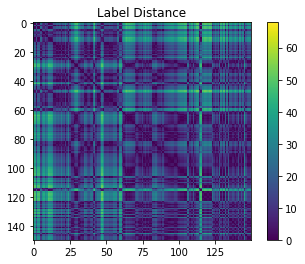

In [5]:
label_distance = np.zeros((len(labels), len(labels)))
for i, label_i in enumerate(labels):
    for j, label_j in enumerate(labels):
        label_distance[i][j] = np.sqrt((label_i - label_j)** 2)
        #label_distance[i][j] = label_i * label_j

plt.imshow(label_distance, cmap = 'viridis')
plt.colorbar()
plt.title('Label Distance')

## Plot spectrum distance

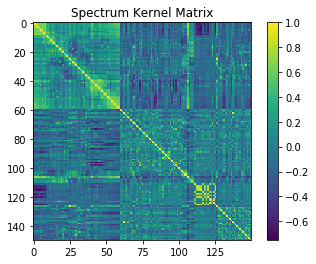

array([[ 1.        ,  0.74453417,  0.74256007, ..., -0.49583973,
        -0.42357737, -0.36054321],
       [ 0.74453417,  1.        ,  0.77594005, ..., -0.33593937,
        -0.28503148, -0.2371463 ],
       [ 0.74256007,  0.77594005,  1.        , ..., -0.33902732,
        -0.28790792, -0.24026394],
       ...,
       [-0.49583973, -0.33593937, -0.33902732, ...,  1.        ,
         0.05095664,  0.13177661],
       [-0.42357737, -0.28503148, -0.28790792, ...,  0.05095664,
         1.        , -0.08257162],
       [-0.36054321, -0.2371463 , -0.24026394, ...,  0.13177661,
        -0.08257162,  1.        ]])

In [6]:
spec_kernel.__call__(frr_seqs, frr_seqs, plot_flag=plot_flag)

Text(0.5, 1.0, 'Spectrum Distance')

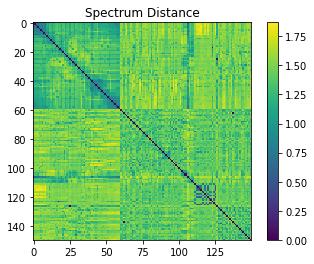

In [7]:
spec_distance, phi_X, phi_Y = spec_kernel.distance(frr_seqs, frr_seqs)
plt.imshow(spec_distance, cmap = 'viridis')
plt.colorbar()
plt.title('Spectrum Distance')

In [8]:
phi_X.shape

(150, 64)

## Weighted Degree Kernel

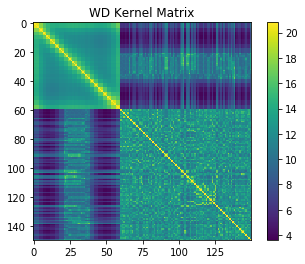

array([[20.81081081, 18.82362479, 18.82362479, ...,  8.72358868,
         8.64641674, 11.79044204],
       [18.82362479, 20.81081081, 20.20974801, ...,  6.73640266,
         6.65923072,  9.80325602],
       [18.82362479, 20.20974801, 20.81081081, ...,  6.73640266,
         6.65923072,  9.80325602],
       ...,
       [ 8.72358868,  6.73640266,  6.73640266, ..., 20.81081081,
        12.57290407, 12.87348973],
       [ 8.64641674,  6.65923072,  6.65923072, ..., 12.57290407,
        20.81081081, 10.91810449],
       [11.79044204,  9.80325602,  9.80325602, ..., 12.87348973,
        10.91810449, 20.81081081]])

In [9]:
wd_kernel.__call__(frr_seqs, frr_seqs, plot_flag=plot_flag)

Text(0.5, 1.0, 'WD Distance')

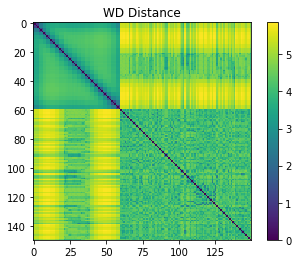

In [10]:
wd_distance = wd_kernel.distance(frr_seqs, frr_seqs, plot_flag=plot_flag)
plt.imshow(wd_distance, cmap = 'viridis')
plt.colorbar()
plt.title('WD Distance')

## Edit distance

In [11]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

Text(0.5, 1.0, 'Edit Distance')

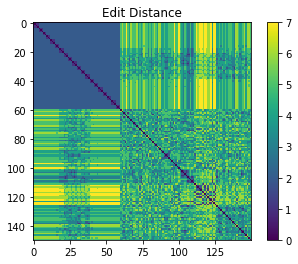

In [12]:
edit_distance = np.zeros((len(frr_seqs), len(frr_seqs)))
for i, seq_i in enumerate(frr_seqs):
    for j, seq_j in enumerate(frr_seqs):
        edit_distance[i][j] = levenshtein(seq_i, seq_j)
        #label_distance[i][j] = label_i * label_j

plt.imshow(edit_distance, cmap = 'viridis')
plt.colorbar()
plt.title('Edit Distance')

# Sort sequences

For sorting the kernel matrix. First, sort by the blocks:
1. reference sequence (only 1)
2. bps core
3. bps non core
2. uniform random
3. weighted random
6. bandit

Within each block, run k-means++ with something like 7 or 11 clusters.
1. sort clusters from large to small
2. within each cluster sort alphabetically

One extra point (in case it is not obvious), which is that all the heatmaps should have the same sorting. So, choose the sorting based on one matrix. I suggest using the squared difference of the TIR scores (the label distance matrix) to sort.

In [13]:
group_dict = df.groupby('Group').groups
new_ordering = [0] # idx ordering
kmeans_based_on = 'label_distance'

In [14]:


for group in groups:
    df_group = df[df['Group'] == group]
    num_seqs = len(df_group)
    num_clusters = int(num_seqs/4) + 1
    print('Group: ', group)
    print('Number of sequences: ', num_seqs)
    print('number of clusters: ', num_clusters)
    
    idx = np.asarray(group_dict[group])
    print('idx: ', idx)
    #print(label_distance[idx[0]: idx[-1], idx[0]: idx[-1]])
    
    
    if kmeans_based_on == 'label_distance': # kmeans based on label distances
        kmeans = KMeans(n_clusters = num_clusters, random_state = 0).fit(np.asarray(df['AVERAGE'])[idx[0]: idx[-1] + 1].reshape(len(idx),1))
        cluster_dict = defaultdict(list) # key: cluster id; value: idx list
        for i, cluster_id in enumerate(kmeans.labels_):
            cluster_dict[cluster_id].append(idx[i])
        print('cluster dict: ', cluster_dict)
        print('kmeans labels: ', kmeans.labels_)
        
    elif kmeans_based_on == 'spec_distance': # kmeans based on spectrum distances 
        #kmeans = KMeans(n_clusters = num_clusters, random_state = 0).fit(phi_X[idx[0]: idx[-1] + 1, :])
        model = AgglomerativeClustering(n_clusters=num_clusters)
        model.fit(phi_X[idx[0]: idx[-1] + 1, :])
        cluster_dict = defaultdict(list) # key: cluster id; value: idx list
        for i, cluster_id in enumerate(model.labels_):
            cluster_dict[cluster_id].append(idx[i])
        print('cluster dict: ', cluster_dict)
        print('kmeans labels: ', model.labels_)

    print('Sorting inside clusterings:')
    for key, value in cluster_dict.items():
        seq_list = []
        for i in value:
            seq_list.append(frr_seqs[i])
        print('key: ', key)
        print('seq list: ', seq_list)
        
        argsorted_seq_list = np.argsort(seq_list)
        print('argsorted seq list: ', argsorted_seq_list)
        
        cluster_dict[key] = np.asarray(value)[np.asarray(argsorted_seq_list)]
    print('sorted cluster dict: ', cluster_dict)
    
    print('Sorting clusterings:')
    
    
    if kmeans_based_on == 'label_distance':
        print('kmeans cluster center: ', kmeans.cluster_centers_)
        argsorted_cluster_ids = np.argsort(kmeans.cluster_centers_.reshape(num_clusters,))[::-1]
    else:
        # TODO: check
        argsorted_cluster_ids = range(num_clusters)
        
    print('argsort kmeans cluster center: ', argsorted_cluster_ids)
    for cluster_id in argsorted_cluster_ids:
        for i in cluster_dict[cluster_id]:   
            new_ordering.append(i)
            
    print('new ordering: ', new_ordering)
    print()                                                      

Group:  bps
Number of sequences:  60
number of clusters:  16
idx:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
cluster dict:  defaultdict(<class 'list'>, {4: [0], 1: [1, 3, 4, 10, 11, 12], 2: [2, 14, 15, 35, 44, 49, 50, 51], 11: [5, 25, 37, 43], 14: [6, 9, 46], 6: [7, 24], 10: [8, 19, 55, 56, 57], 8: [13, 48, 59], 7: [16, 18, 20, 39], 12: [17, 21, 23, 36, 40, 45, 52, 53, 54], 3: [22, 32, 34], 0: [26, 27, 31], 5: [28, 41], 9: [29, 30, 42], 13: [33, 38, 58], 15: [47]})
kmeans labels:  [ 4  1  2  1  1 11 14  6 10 14  1  1  1  8  2  2  7 12  7 10  7 12  3 12
  6 11  0  0  5  9  9  0  3 13  3  2 12 11 13  7 12  5  9 11  2 12 14 15
  8  2  2  2 12 12 12 10 10 10 13  8]
Sorting inside clusterings:
key:  4
seq list:  ['TTTAAGAAGGAGATATACAT']
argsorted seq list:  [0]
key:  1
seq list:  ['CTTAAGAAGGAGATATACAT', 'ATTAAGAAGGAGATATACAT', 'TCTAAGAAGGAGATATACAT',

cluster dict:  defaultdict(<class 'list'>, {1: [89, 106, 123], 2: [90, 91, 92, 97, 98], 9: [93, 94, 108, 125], 5: [95, 96, 99, 107], 7: [100, 101, 102, 103, 109, 111], 0: [104, 105, 116, 117, 120], 6: [110, 124], 8: [112, 113, 118, 119, 121, 122], 4: [114], 3: [115]})
kmeans labels:  [1 2 2 2 9 9 5 5 2 2 5 7 7 7 7 0 0 1 5 9 7 6 7 8 8 4 3 0 0 8 8 0 8 8 1 6 9]
Sorting inside clusterings:
key:  1
seq list:  ['TTTAAGACGGATTTATACAT', 'TTTAAGAGGAAGATATACAT', 'TTTAAGAGGATAATATACAT']
argsorted seq list:  [0 1 2]
key:  2
seq list:  ['TTTAAGACTCGGATATACAT', 'TTTAAGAACCGGATATACAT', 'TTTAAGAATCGGATATACAT', 'TTTAAGACTCTCTTATACAT', 'TTTAAGAATATATTATACAT']
argsorted seq list:  [1 4 2 0 3]
key:  9
seq list:  ['TTTAAGACCGGATTATACAT', 'TTTAAGACGATAATATACAT', 'TTTAAGAGGATCGTATACAT', 'TTTAAGATTTTTTTATACAT']
argsorted seq list:  [0 1 2 3]
key:  5
seq list:  ['TTTAAGAACACACTATACAT', 'TTTAAGATATATATATACAT', 'TTTAAGATGTGTGTATACAT', 'TTTAAGAGGGATATATACAT']
argsorted seq list:  [0 3 1 2]
key:  7
seq list:  ['TT

Text(0.5, 1.0, 'Sorted Label Distance')

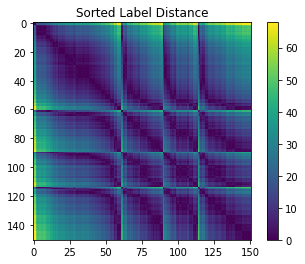

In [15]:
sorted_label_distance = label_distance[:, new_ordering][new_ordering, :]

plt.imshow(sorted_label_distance, cmap = 'viridis')
plt.colorbar()
plt.title('Sorted Label Distance')

Text(0.5, 1.0, 'Sorted Spectrum Distance')

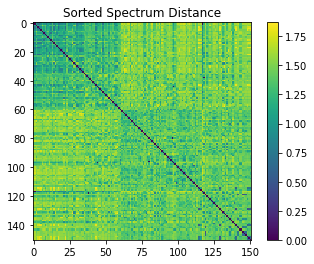

In [16]:
sorted_spec_distance = spec_distance[:, new_ordering][new_ordering, :]
plt.imshow(sorted_spec_distance, cmap = 'viridis')
plt.colorbar()
plt.title('Sorted Spectrum Distance')

Text(0.5, 1.0, 'Sorted WD Distance')

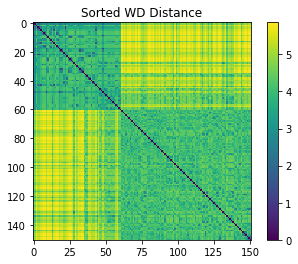

In [17]:
sorted_wd_distance = wd_distance[:, new_ordering][new_ordering, :]
plt.imshow(sorted_wd_distance, cmap = 'viridis')
plt.colorbar()
plt.title('Sorted WD Distance')


Text(0.5, 1.0, 'Sorted Edit Distance')

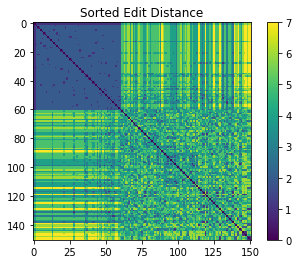

In [18]:
sorted_edit_distance = edit_distance[:, new_ordering][new_ordering, :]
plt.imshow(sorted_edit_distance, cmap = 'viridis')
plt.colorbar()
plt.title('Sorted Edit Distance')


## Plot together

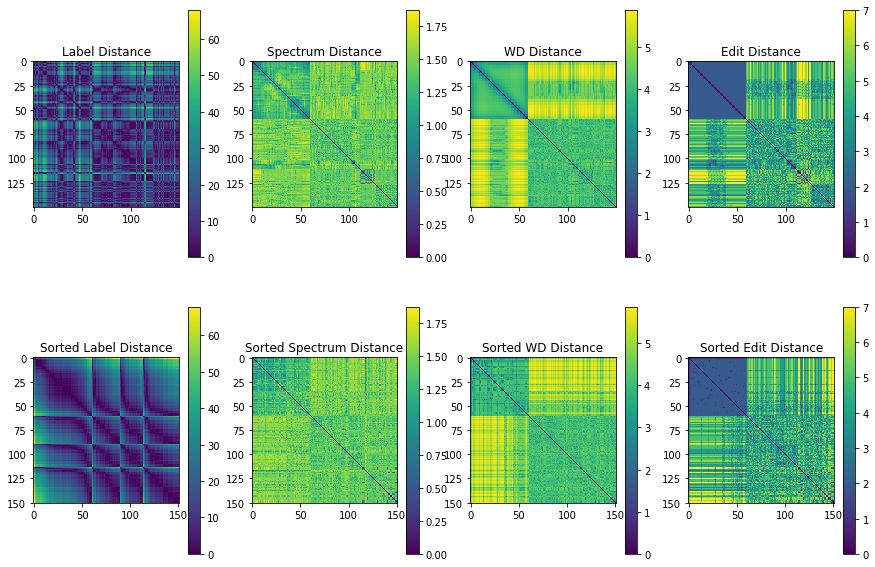

In [19]:
num_rows = 2
num_cols = 4

distance_matrix = [label_distance, spec_distance, wd_distance, edit_distance,\
                   sorted_label_distance, sorted_spec_distance, sorted_wd_distance, sorted_edit_distance,]
distance_matrix_name = ['Label Distance', 'Spectrum Distance', 'WD Distance', 'Edit Distance',\
                        'Sorted Label Distance', 'Sorted Spectrum Distance', 'Sorted WD Distance', 'Sorted Edit Distance']

fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

row_idx = 0
col_idx = 0

for i in range(len(distance_matrix)):
    im = a[row_idx][col_idx].imshow(distance_matrix[i], cmap = 'viridis')
    fig.colorbar(im, ax =a[row_idx][col_idx])
    a[row_idx][col_idx].set_title(distance_matrix_name[i])
    
    if col_idx == num_cols -1:
        row_idx += 1
        col_idx = 0
    else:
        col_idx += 1
    
plt.savefig('Distance_plot.png')
plt.show()

In [20]:
from scipy import stats

stats.spearmanr(np.triu(sorted_label_distance).flatten(), np.triu(sorted_spec_distance).flatten())

SpearmanrResult(correlation=0.8816022033029631, pvalue=0.0)

In [21]:
stats.spearmanr(np.triu(sorted_label_distance).flatten(), np.triu(sorted_wd_distance).flatten())

SpearmanrResult(correlation=0.901897715188102, pvalue=0.0)

In [22]:
stats.spearmanr(np.triu(sorted_label_distance).flatten(), np.triu(sorted_edit_distance).flatten())

SpearmanrResult(correlation=0.8815200718855304, pvalue=0.0)

In [23]:
stats.spearmanr(np.triu(sorted_spec_distance).flatten(), np.triu(sorted_edit_distance).flatten())

SpearmanrResult(correlation=0.9407968226126857, pvalue=0.0)